# 💻 01 - Visual control

Details go here...

In [1]:
### Run this cell to import relevant modules
#%load_ext autoreload
#%autoreload 2
#%matplotlib inline
#%pylab inline

from matplotlib import pyplot as plt
import numpy as np
import cv2

In [6]:
# Load in the image and convert it to grayscale
imgrgb = cv2.imread('./images/visual_control/duckietown-lane-crop-small.jpg', 0)
#img = cv2.cvtColor(imgrgb, cv2.COLOR_BGR2GRAY)

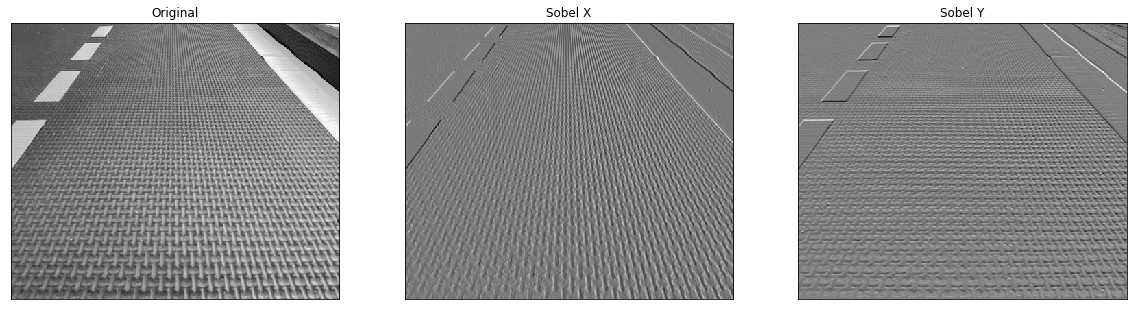

In [190]:


# Convolve the image with the Sobel operator (filter) to compute the numerical derivatives in the x and y directions
sobelx = cv2.Sobel(img_gray,cv2.CV_64F,1,0)
sobely = cv2.Sobel(img_gray,cv2.CV_64F,0,1)

fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img_gray,cmap = 'gray')
ax1.set_title('Original'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(sobelx,cmap = 'gray')
ax2.set_title('Sobel X'), ax2.set_xticks([]), ax2.set_yticks([])
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(sobely,cmap = 'gray')
ax3.set_title('Sobel Y'), ax3.set_xticks([]), ax3.set_yticks([]);

In [ ]:
# TODO: Experiment with different settings for the standard deviation of the Gaussian and compare the results to a box filter.
#.      Identify a setting for the standard deviation that removes noise while not eliminating too much valid content.
sigma = 1

# Smooth the image using a Gaussian kernel
img_gaussian_filter = cv2.GaussianBlur(img,(0,0), sigma)

# Visualize the filtered image alongside the original image.
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img,cmap = 'gray')
ax1.set_title('Original'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(img_gaussian_filter,cmap = 'gray')
ax2.set_title('Gaussian Filter (Sigma = ' + str(sigma) +')'), ax2.set_xticks([]), ax2.set_yticks([]);
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(img_box_filter,cmap = 'gray')
ax3.set_title('Box Filter'), ax3.set_xticks([]), ax3.set_yticks([]);

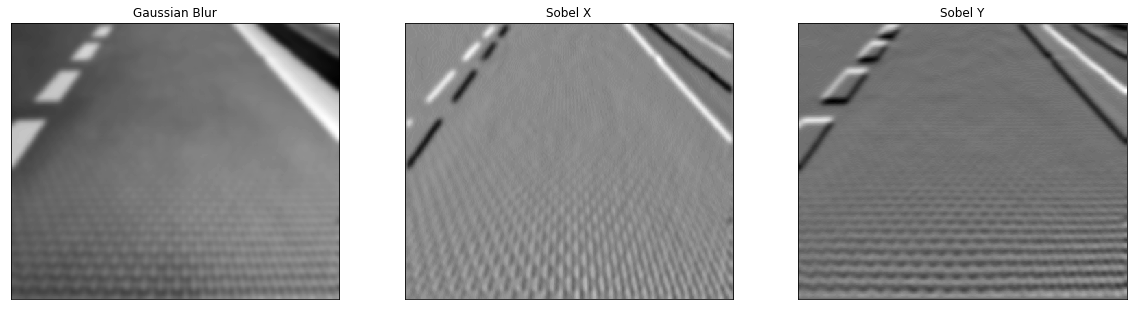

In [191]:
# Now smooth the image with a Gaussian kernel
img_gray_blurred = cv2.GaussianBlur(img_gray,(0,0), 4)

# Convolve the image with the Sobel operator (filter) to compute the numerical derivatives in the x and y directions
sobelx = cv2.Sobel(img_gray_blurred,cv2.CV_64F,1,0)
sobely = cv2.Sobel(img_gray_blurred,cv2.CV_64F,0,1)

fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img_gray_blurred,cmap = 'gray')
ax1.set_title('Gaussian Blur'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(sobelx,cmap = 'gray')
ax2.set_title('Sobel X'), ax2.set_xticks([]), ax2.set_yticks([])
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(sobely,cmap = 'gray')
ax3.set_title('Sobel Y'), ax3.set_xticks([]), ax3.set_yticks([]);

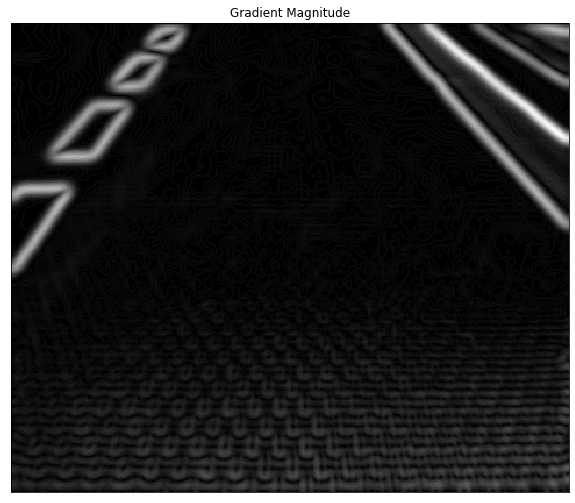

In [193]:
# Compute the magnitude of the gradients
Gmag = np.sqrt(sobelx*sobelx + sobely*sobely)

# Compute the orientation of the gradients
Gdir = cv2.phase(np.array(sobelx, np.float32), np.array(sobely, dtype=np.float32), angleInDegrees=True)
#Gdir = np.arctan2(np.array(sobelx, np.float32), np.array(sobely, np.float32))

# Render the gradient magnitude
Gmag_8u = np.uint8(Gmag)
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(Gmag_8u, cmap = 'gray')
ax1.set_title('Gradient Magnitude'), ax1.set_xticks([]), ax1.set_yticks([]);

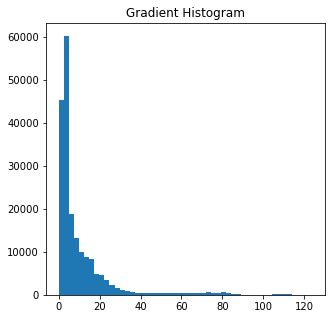

In [195]:
# Visualize the histogram over gradient magnitudes
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(1,1,1)
ax1.hist(Gmag.flatten(), bins=50)
ax1.set_title('Gradient Histogram');

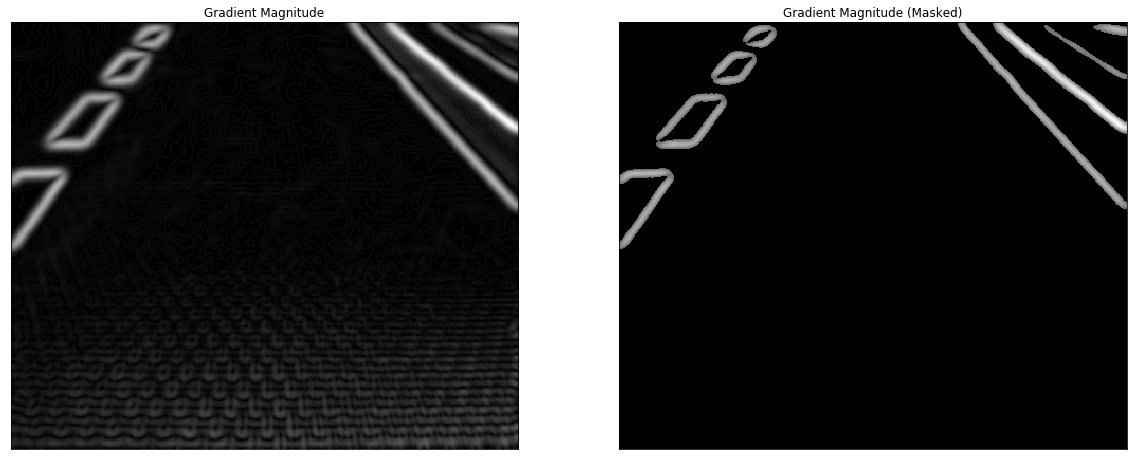

In [203]:
# We are only intersted in edges with stronger gradients and need to identify a threshold on the magnitude below which we ignore gradients. We can pick a threshold based on the histogram above and the resulting masked gradient magnitude image
threshold = 50
mask_mag = (Gmag > threshold)
#plt.imshow(mask_mag*Gmag)

fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(Gmag_8u, cmap = 'gray')
ax1.set_title('Gradient Magnitude'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(mask_mag*Gmag_8u,cmap = 'gray')
ax2.set_title('Gradient Magnitude (Masked)'), ax2.set_xticks([]), ax2.set_yticks([]);

In [204]:
# Let's consider the filter responses for the left- and right-halves of the image
width = img_gray.shape[1]
mask_left = np.ones(sobelx.shape)
mask_left[:,int(np.floor(width/2)):width + 1] = 0
mask_right = np.ones(sobelx.shape)
mask_right[:,0:int(np.floor(width/2))] = 0

In [143]:
# In the left-half image, we are interested in the right-half of the dashed yellow line, which corresponds to negative x- and y-derivatives
# In the right-half image, we are interested in the left-half of the solid white line, which correspons to a positive x-derivative and a negative y-derivative
# Generate a mask that identifies pixels based on the sign of their x-derivative
mask_sobelx_pos = (sobelx > 0)
mask_sobelx_neg = (sobelx < 0)

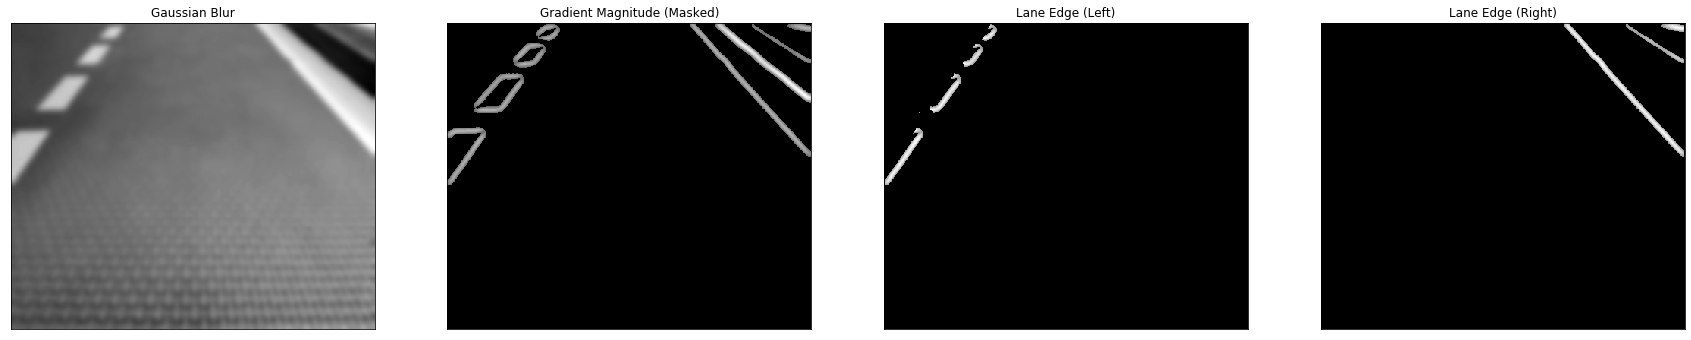

In [207]:
# Let's combine these masks with the gradient magnitude mask
mask_left_edge = mask_left * mask_mag * mask_sobelx_neg
mask_right_edge = mask_right * mask_mag * mask_sobelx_pos

fig = plt.figure(figsize = (30,20))
ax1 = fig.add_subplot(1,4,1)
ax1.imshow(img_gray_blurred,cmap = 'gray')
ax1.set_title('Gaussian Blur'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,4,2)
ax2.imshow(mask_mag*Gmag,cmap = 'gray')
ax2.set_title('Gradient Magnitude (Masked)'), ax2.set_xticks([]), ax2.set_yticks([])
ax3 = fig.add_subplot(1,4,3)
ax3.imshow(Gmag * mask_left_edge, cmap = 'gray')
ax3.set_title('Lane Edge (Left)'), ax3.set_xticks([]), ax3.set_yticks([])
ax4 = fig.add_subplot(1,4,4)
ax4.imshow(Gmag * mask_right_edge,cmap = 'gray')
ax4.set_title('Lane Edge (Right)'), ax4.set_xticks([]), ax4.set_yticks([]);

Text(0.5, 1.0, 'Gradient Direction Histogram (Left Edge)')

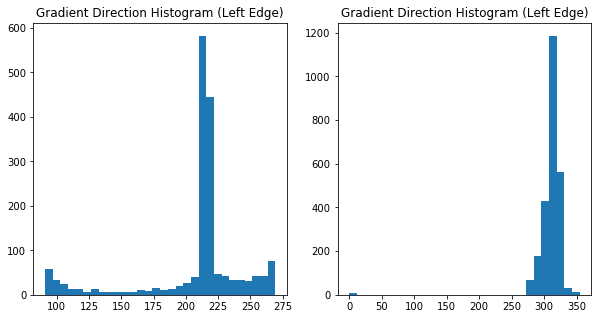

In [163]:
# Now, let's apply the mask to our gradient directions
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.hist(np.extract(mask_left_edge, Gdir).flatten(), bins=30)
ax1.set_title('Gradient Direction Histogram (Left Edge)')
ax2 = fig.add_subplot(1,2,2)
ax2.hist(np.extract(mask_right_edge, Gdir).flatten(), bins=30)
ax2.set_title('Gradient Direction Histogram (Left Edge)')

In [208]:
# Determine the orientation of the left and right gradients as the mode of each histogram
(hist_left_edge, bins_left_edge) = np.histogram(np.extract(mask_left_edge, Gdir).flatten(), bins=30)
(hist_right_edge, bins_right_edge) = np.histogram(np.extract(mask_right_edge, Gdir).flatten(), bins=30)

idx = hist_left_edge.argmax()
theta_left = (bins_left_edge[idx] + bins_left_edge[idx+1])/2
idx = hist_right_edge.argmax()
theta_right = (bins_right_edge[idx] + bins_right_edge[idx+1])/2

In [209]:
theta_right

313.2401428222656

In [97]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = np.array([np.extract(mask, sobelx).flatten(), np.extract(mask, sobely).flatten()])
pca.fit(X.transpose())


PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [88]:
pca.components_.shape

(2, 2)

In [98]:
#print(pca.singular_values_)
print(pca.components_[:,0:2])
temp = cv2.phase(np.array(pca.components_[0,:], np.float32), np.array(pca.components_[1,:], dtype=np.float32), angleInDegrees=True)

[[-0.54181743  0.84049621]
 [ 0.84049621  0.54181743]]


In [94]:
np.arctan2(-0.88186811, -0.47149616)*180/np.pi


-118.13145953754726